In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import tcm

In [24]:
fitname = "250519-jth-exa-nnlo-alphas_mt_mtt_tcm_iterated"
pred_mtt, P_tilde_mtt = tcm.compute_posterior(fitname)
fitname = "250519-jth-exa-nnlo-alphas_mt_pTt_tcm_iterated"
pred_pTt, P_tilde_pTt = tcm.compute_posterior(fitname)
fitname = "250519-jth-exa-nnlo-alphas_mt_y_tcm_iterated"
pred_y, P_tilde_y = tcm.compute_posterior(fitname)

LHAPDF 6.5.5 loading /Users/jaco/miniconda3/envs/nnpdf_dev/share/LHAPDF/250519-jth-exa-nnlo-alphas_mt_mtt_tcm/250519-jth-exa-nnlo-alphas_mt_mtt_tcm_0000.dat
250519-jth-exa-nnlo-alphas_mt_mtt_tcm PDF set, member #0, version 1
LHAPDF 6.5.5 loading all 101 PDFs in set 250519-jth-exa-nnlo-alphas_mt_mtt_tcm_iterated
250519-jth-exa-nnlo-alphas_mt_mtt_tcm_iterated, version 1; 101 PDF members
LHAPDF 6.5.5 loading /Users/jaco/miniconda3/envs/nnpdf_dev/share/LHAPDF/250519-jth-exa-nnlo-alphas_mt_pTt_tcm/250519-jth-exa-nnlo-alphas_mt_pTt_tcm_0000.dat
250519-jth-exa-nnlo-alphas_mt_pTt_tcm PDF set, member #0, version 1
LHAPDF 6.5.5 loading all 101 PDFs in set 250519-jth-exa-nnlo-alphas_mt_pTt_tcm_iterated
250519-jth-exa-nnlo-alphas_mt_pTt_tcm_iterated, version 1; 101 PDF members
LHAPDF 6.5.5 loading /Users/jaco/miniconda3/envs/nnpdf_dev/share/LHAPDF/250519-jth-exa-nnlo-alphas_mt_y_tcm/250519-jth-exa-nnlo-alphas_mt_y_tcm_0000.dat
250519-jth-exa-nnlo-alphas_mt_y_tcm PDF set, member #0, version 1
LHAPD

In [ ]:
# fitname = "250519-jth-exa-nnlo-alphas_mt_mtt_tcm"
# pred_mtt_non_iterated, P_tilde_mtt_non_iterated = tcm.compute_posterior(fitname)
# fitname = "250519-jth-exa-nnlo-alphas_mt_pTt_tcm"
# pred_pTt_non_iterated, P_tilde_pTt_non_iterated = tcm.compute_posterior(fitname)
# fitname = "250519-jth-exa-nnlo-alphas_mt_y_tcm"
# pred_y_non_iterated, P_tilde_y_non_iterated = tcm.compute_posterior(fitname)

In [20]:
def plot_ellipse(mu0, sigma, labels, output):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    hndls = []
    colors=["C0", "C1", "C2", "C3", "C4", "C5"]
    for i, (mu0_i, sigma_i) in enumerate(zip(mu0, sigma)):
        p1 = tcm.confidence_ellipse(
            sigma_i,
            mu0_i,
            ax=ax,
            alpha=1,
            edgecolor=colors[i],
            confidence_level=68,
        )
        
        p2 = tcm.confidence_ellipse(
            sigma_i,
            mu0_i,
            ax=ax,
            alpha=0.3,
            edgecolor=None,
            facecolor=colors[i],
            confidence_level=68,
        )
        
        ax.scatter(
            mu0_i[0], mu0_i[1],
            c='k',
            s=20,
            marker="+",
        )
        
        hndls.append((p1, p2))
        
        # msbar_to_pole = 10.38
        # pred_abmp = [160.6 + msbar_to_pole, 0.115]
        # cov_abmp = np.array([[0.6 ** 2, 0], [0, 0.0009 ** 2]])
        
        
    ax.tick_params(top=True, right=True, direction="in")
    plt.xlabel(r'$m_{t}\:{\rm [GeV]}$', fontsize=15)
    plt.ylabel(r'$\alpha_s$', fontsize=15)
    plt.title(r"$68\%\:\rm{C.L.\:interval}$", fontsize=15)
    plt.grid(True)
    
    mt_pdg = 172.4
    as_pdg = 0.118
    
    #ax.set_xlim(171.5, 173.0)
    #ax.set_ylim(pred[1] - 0.0015, pred[1] + 0.0015)
    
    ax.legend(
        labels=labels,
        handles=hndls,
        loc="upper left",
        frameon=False,
        fontsize=15,
        handlelength=1,
        borderpad=0.5,
        handletextpad=1,
        title_fontsize=24,
    )
    plt.savefig(f"plots/{output}.pdf")
    plt.show()



In [75]:
chi2_values_exp_method = pd.read_csv("./results/250524-jth-exa-nnlo-mhou-mtt_alphas-exp.dat", sep='\t')

In [77]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

def paraboloid(xy, a, b, c, d, e, f):
    x, y = xy
    return a*x**2 + b*y**2 + c*x*y + d*x + e*y + f

# Fit the paraboloid model to the data
ndata = 4655
xdata = chi2_values_exp_method["m_t"].values
ydata = chi2_values_exp_method["alpha_s"].values
zdata = chi2_values_exp_method["chi2"].values * ndata
params, covariance = curve_fit(paraboloid, (xdata, ydata), zdata)
a, b, c, d, e, f = params


In [78]:
det_params = 4 * a * b - c ** 2 
mt_best = (-2 * b * d + c * e) / det_params
as_best = (c * d - 2 * a * e) / det_params
cv_exp_mtt = np.array([mt_best, as_best]) 

In [80]:
cv_exp_mtt

array([1.71665468e+02, 1.20578440e-01])

In [79]:
cov_exp = 2 * np.array([[2 * b, -c], [-c, 2 * a]]) / det_params

In [64]:
np.sqrt(P_tilde_mtt[1,1]/cov_exp[1,1])

3.815914520177468

In [65]:
np.sqrt(cov_exp[1,1])

0.0001444988729034078

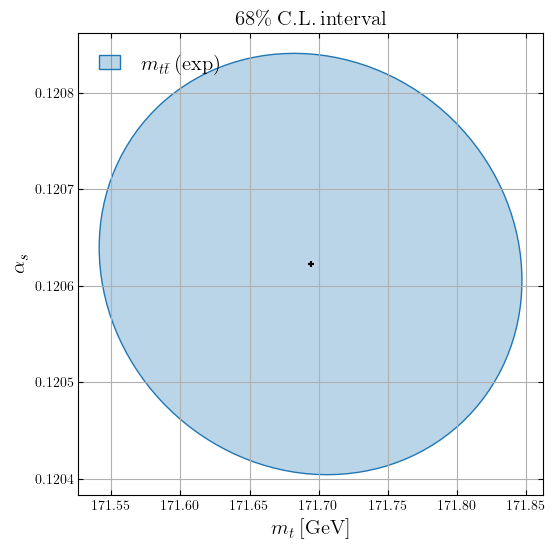

In [66]:
plot_ellipse(
    mu0=[cv_exp_mtt],
    sigma=[cov_exp],labels=[r"$m_{t\bar{t}}\:\mathrm{(exp)}$"],
    output="exp_exa-nnlo-mhou-mtt-alphas_mt",)

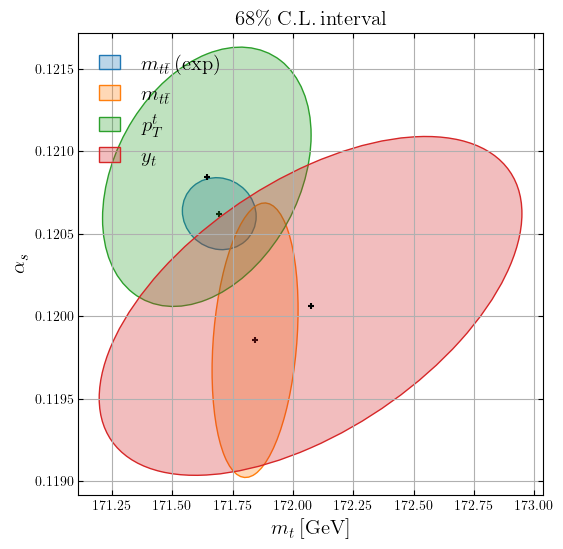

In [67]:
plot_ellipse(
    mu0=[cv_exp_mtt, pred_mtt, pred_pTt, pred_y],
    sigma=[cov_exp, P_tilde_mtt, P_tilde_pTt, P_tilde_y],labels=[r"$m_{t\bar{t}}\:\mathrm{(exp)}$", r"$m_{t\bar{t}}$", r"$p_T^t$", r"$y_t$"],
    output="tcm-exa-nnlo-mhou-alphas_mt")

In [68]:
# select rows where m_t is 172.5
alphas_mt_172_5 = chi2_values_exp_method[chi2_values_exp_method["m_t"] == 172.5].values

In [69]:
alphas_mt_172_5

array([[1.15000000e-01, 1.72500000e+02, 1.58515362e+00],
       [1.16000000e-01, 1.72500000e+02, 1.47287606e+00],
       [1.17000000e-01, 1.72500000e+02, 1.38442465e+00],
       [1.19000000e-01, 1.72500000e+02, 1.28214762e+00],
       [1.21000000e-01, 1.72500000e+02, 1.27153951e+00],
       [1.22000000e-01, 1.72500000e+02, 1.28397923e+00],
       [1.23000000e-01, 1.72500000e+02, 1.31304302e+00]])

In [70]:
params_as_mt_172_5, _ = curve_fit(parabola, alphas_mt_172_5[:, 0], alphas_mt_172_5[:, 2] * ndata)


In [73]:
1/np.sqrt(params_as_mt_172_5[0])

0.00014446244630819636

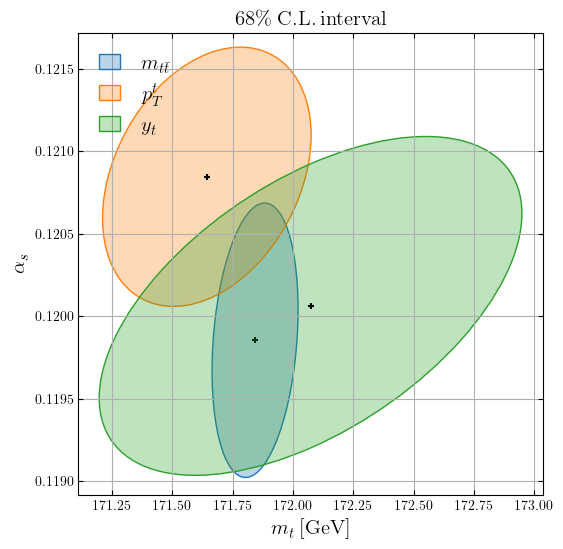

In [74]:
plot_ellipse(
    mu0=[pred_mtt, pred_pTt, pred_y],
    sigma=[P_tilde_mtt, P_tilde_pTt, P_tilde_y],labels=[r"$m_{t\bar{t}}$", r"$p_T^t$", r"$y_t$"],
    output="tcm-exa-nnlo-mhou-alphas_mt_v2")